In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import matplotlib.pyplot as plt

In [2]:
df_movie_details = pd.read_json('../data/IMDB_movie_details.json', lines = True)
df_reviews = pd.read_pickle('../data/cleaned_reviews.pkl.gz', compression = 'gzip')

In [4]:
#Tokenize
df_movie_details['tokenized_synopsis'] = list(map(word_tokenize, df_movie_details['plot_synopsis']))

In [10]:
# Remove stop words
stop_words_and_punctuations = set(stopwords.words('english') + list(string.punctuation))
df_movie_details['tokenized_synopsis'] = list(map(lambda x: [word.lower() for word in x if word.lower() not in stop_words_and_punctuations], df_movie_details['tokenized_synopsis']))

In [11]:
# Stemming
stemmer = PorterStemmer()
df_movie_details['tokenized_synopsis'] = list(map(lambda x: [stemmer.stem(word) for word in x], df_movie_details['tokenized_synopsis']))

In [23]:
df_movie_details['text_tokenized'] = list(map(lambda x: ' '.join(x), df_movie_details['tokenized_synopsis']))
df_movie_details = df_movie_details[df_movie_details['text_tokenized'] != '']
df_reviews = df_reviews[df_reviews['movie_id'].isin(df_movie_details['movie_id'])]
df_movie_details.to_pickle("../data/cleaned_synopsis.pkl.gz", compression = 'gzip')

<ipython-input-23-6f1327d37a39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_details['text_tokenized'] = list(map(lambda x: ' '.join(x), df_movie_details['tokenized_synopsis']))


In [3]:
df_movie_details = pd.read_pickle("../data/cleaned_synopsis.pkl.gz", compression = "gzip")

In [4]:
df_reviews = df_reviews.drop(df_reviews[df_reviews.movie_id == "tt0104014"].index)
df_reviews = df_reviews.drop(df_reviews[df_reviews.movie_id == "tt0114142"].index)

In [78]:
movie_list = set(df_movie_details["movie_id"])
for movie_id in list(df_reviews["movie_id"].unique()):
    if movie_id not in movie_list:
        print(movie_id)

tt0104014
tt0114142


In [25]:
def fit_vectorizer(synopsis):
    vectorizer = TfidfVectorizer(stop_words='english')
    vectorizer.fit([synopsis])
    return vectorizer

# Apply the function to create a new column 'vectorizer'
df_movie_details['vectorizer'] = df_movie_details['text_tokenized'].apply(fit_vectorizer)

In [34]:
# Creating new dataframe for Similarity measure
similarity_data = {'movie_id' : [], 'review_label' : [], 'review_tokenized' : [], 'vectorizer' : [], 'synopsis_tokenized' : [], 'synopsis_tfidf' : [], 'review_tfidf' : []}
for idx in df_reviews.index:
    review = df_reviews.loc[idx, :]
    movie_id = review['movie_id']
    review_tokenized = review['text_tokenized']
    synopsis_tokenized = df_movie_details.loc[df_movie_details['movie_id'] == movie_id]['text_tokenized'].tolist() #get tokenized synopsis of reviewed movie
    vectorizer = df_movie_details.loc[df_movie_details['movie_id'] == movie_id]['vectorizer']
    print(vectorizer)
    synopsis_tfidf = vectorizer.transform(synopsis_tokenized)
    review_tfidf = vectorizer.transform(review_tokenized)
    review_label = review['is_spoiler']

    similarity_data['movie_id'].append(movie_id)
    similarity_data['review_tokenized'].append(review_tokenized)
    similarity_data['synopsis_tokenized'].append(synopsis_tokenized)
    similarity_data["review_label"].append(review_label)
    similarity_data['vectorizer'].append(vectorizer)
    similarit_data['synopsis_tfidf'].append(synopsis_tfidf)
    similarity_data['review_tfidf'].append(review_tfidf)

similarity_df = pd.DataFrame(similarity_data)

1263    TfidfVectorizer(stop_words='english')
Name: vectorizer, dtype: object


ValueError: Transform function failed

In [11]:
similarity_df.to_pickle("../data/similarity.pkl.gz", compression = "gzip")

In [8]:
similarity_df = pd.read_pickle("../data/similarity.pkl.gz", compression = "gzip")

In [12]:
tfidfvectorizer = TfidfVectorizer()
tfidfvectorizer.fit(similarity_df["review_tokenized"] + similarity_df["synopsis_tokenized"])

TfidfVectorizer()

In [13]:
synopsis_tfidf = tfidfvectorizer.transform(similarity_df["synopsis_tokenized"])

In [14]:
synopsis_tfidf

<573906x519982 sparse matrix of type '<class 'numpy.float64'>'
	with 269581411 stored elements in Compressed Sparse Row format>

In [15]:
review_tfidf = tfidfvectorizer.transform(similarity_df["review_tokenized"])

In [16]:
review_tfidf

<573906x519982 sparse matrix of type '<class 'numpy.float64'>'
	with 62630753 stored elements in Compressed Sparse Row format>

In [21]:
for idx in similarity_df.index:
    similarity_df.loc[idx, 'similarity_score'] = cosine_similarity(review_tfidf[idx], synopsis_tfidf[idx]).tolist()[0]

In [35]:
similarity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573906 entries, 0 to 573905
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            573906 non-null  object 
 1   review_label        573906 non-null  bool   
 2   review_tokenized    573906 non-null  object 
 3   synopsis_tokenized  573906 non-null  object 
 4   similarity_score    573906 non-null  float64
dtypes: bool(1), float64(1), object(3)
memory usage: 18.1+ MB


In [37]:
spoiler = similarity_df.loc[similarity_df["review_label"] == True]
non_spoiler = similarity_df.loc[similarity_df["review_label"] == False].sample(n = spoiler["review_label"].count())
similarity_df_new = pd.concat([spoiler, non_spoiler])

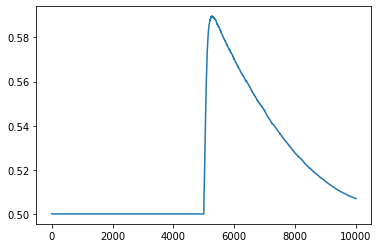

In [41]:
accuracy = []
max_acc = float('-inf')
for threshold in np.arange(-0.5, 0.5, 0.0001):
    pred = similarity_df_new["similarity_score"] > threshold
    acc = (pred == similarity_df_new["review_label"]).sum()/pred.count()
    accuracy.append(acc)
    max_acc = max(acc, max_acc)
plt.plot(accuracy)

In [42]:
max_acc

0.5896378309612785

In [44]:
similarity_df.groupby("review_label").count()

,movie_id,review_tokenized,synopsis_tokenized,similarity_score
review_label,,,,
False,422982,422982,422982,422982
True,150924,150924,150924,150924
